In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tapakah68/supervisely-filtered-segmentation-person-dataset")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/tapakah68/supervisely-filtered-segmentation-person-dataset/versions/3


In [4]:
# %matplotlib inline
# import warnings
# warnings.filterwarnings("ignore")
# warnings.simplefilter("ignore")
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import keras.backend as K
import tensorflow as tf
import keras.backend as K
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Dropout, Normalization
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import binary_crossentropy
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models

In [6]:
# Adjust parameters
input_size = (256, 256, 3)
batch_size = 8  # 8, 16, 32
seed = 42
epochs = 50

## **2.Load, prepare and preprocessing of data**
***

In [7]:
# directory of data
image_folder = "/root/.cache/kagglehub/datasets/tapakah68/supervisely-filtered-segmentation-person-dataset/versions/3/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images"
mask_folder = "/root/.cache/kagglehub/datasets/tapakah68/supervisely-filtered-segmentation-person-dataset/versions/3/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/masks"

# Get path
image_paths = [os.path.join(image_folder, img) for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
mask_paths = [os.path.join(mask_folder, mask) for mask in sorted(os.listdir(mask_folder)) if mask.endswith(".png")]

In [8]:
def load_image(image_path, target_size=(256, 256)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    if image.shape[-1] == 1:  # If grayscale, convert to RGB
        image = np.repeat(image, 3, axis=-1)
    image = image / 255.0
    return image

# Load mask
def load_mask(mask_path, target_size=(256, 256)):
    mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
    mask = img_to_array(mask)
    mask = mask / 255.0
    mask = np.round(mask)  # Ensure mask is binary
    return mask

In [9]:
# Split dataset into train, validation and test
X_train, X_validation, y_train, y_validation = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_validation, y_validation, test_size=0.5, random_state=seed)
print(f"Training set:   X: {len(X_train)}, y: {len(y_train)}")
print(f"Validation set:   X: {len(X_validation)}, y: {len(y_validation)}")
print(f"Val set:   X: {len(X_val)}, y: {len(y_val)}")
print(f"Test set:  X: {len(X_test)}, y: {len(y_test)}")

Training set:   X: 2133, y: 2133
Validation set:   X: 534, y: 534
Val set:   X: 267, y: 267
Test set:  X: 267, y: 267


In [10]:
# Data agumentation
data_gen_args = dict(rotation_range=45,
                     width_shift_range=0.03,
                     height_shift_range=0.03,
                     shear_range=0.03,
                     zoom_range=0.03,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode="nearest")

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [11]:
# Define a custom generator(for training data)
def train_generator(image_paths, mask_paths, batch_size):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            X_batch = []
            Y_batch = []
            for img_path, msk_path in zip(image_paths[start:end], mask_paths[start:end]):
                image = load_image(img_path)
                mask = load_mask(msk_path)
                X_batch.append(image)
                Y_batch.append(mask)
            X_batch = np.array(X_batch)
            Y_batch = np.array(Y_batch)
            seed = np.random.randint(1e6)
            X_batch_aug = next(image_datagen.flow(X_batch, batch_size=batch_size, seed=seed))
            Y_batch_aug = next(mask_datagen.flow(Y_batch, batch_size=batch_size, seed=seed))

            yield X_batch_aug, Y_batch_aug

train_gen = train_generator(X_train, y_train, batch_size)
steps_per_epoch = len(X_train) // batch_size


# Load validation and test data into memory
X_val = np.array([load_image(img_path) for img_path in X_val])
y_val = np.array([load_mask(msk_path) for msk_path in y_val])

X_test = np.array([load_image(img_path) for img_path in X_test])
y_test = np.array([load_mask(msk_path) for msk_path in y_test])


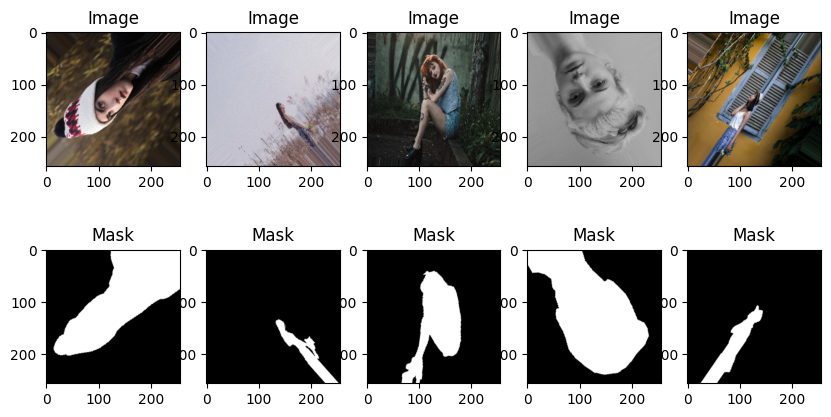

In [12]:
# Generate a batch of augmented images and masks for visualization
images, masks = next(train_gen)

# Visualize the augmented images and masks
plt.figure(figsize=(10,8))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.title("Image")
    plt.imshow(images[i])

    plt.subplot(3, 5, i+6)
    plt.title("Mask")
    plt.imshow(masks[i].squeeze(), cmap="gray")

plt.show()

## **3.Creat the model**
***

In [13]:
# Defibne function for upsampling and concatenating skip connections
def upsample_concat_block(x, skip):
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, skip], axis=3)
    return x

# Define function to build U-Net model with ResNet50 as the encoder
def build_unet_resnet50(input_shape=(256, 256, 3)):
    # Input layer
    inputs = Input(input_shape)

    # Load the ResNet50 model pretrained on ImageNet without the fully connected layers
    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    # Extract layers for skip connections
    skip1 = base_model.get_layer("conv1_relu").output  # 128x128
    skip2 = base_model.get_layer("conv2_block3_out").output  # 64x64
    skip3 = base_model.get_layer("conv3_block4_out").output  # 32x32
    skip4 = base_model.get_layer("conv4_block6_out").output  # 16x16

    # Last layer of ResNet50 before the upsampling begin
    x = base_model.get_layer("conv5_block3_out").output  # 8x8

    # Decoder (upsampling path)
    x = upsample_concat_block(x, skip4)  # 16x16
    x = Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)


    x = upsample_concat_block(x, skip3)  # 32x32
    x = Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = upsample_concat_block(x, skip2)  # 64x64
    x = Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)


    x = upsample_concat_block(x, skip1)  # 128x128
    x = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Final upsampling to reach the original input resolution
    x = UpSampling2D((2, 2))(x)  # 256x256
    x = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv2D(2, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(x)

    # Final output layer (single channel for binary classification)
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(x)

    # Create the model
    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

# Define input shape
input_shape = (256, 256, 3)

# Build the model
model = build_unet_resnet50(input_shape)

# Get summary of model
# model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## **4.Train and evaluate the model**
****

In [14]:
# Define funtion for IOU metric
def iou_metric(y_true, y_pred, smooth=1e-4):
    # Flatten the arrays to handle individual pixels
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Threshold predictions to make them binary (0 or 1)
    y_pred_f = K.cast(y_pred_f > 0.5, dtype="float32")

    # Calculate intersection and union
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    # Calculate IoU
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss="binary_crossentropy",
              metrics=[iou_metric])

In [15]:
# early stopping, reduce learning rate and chcke point for the model
early_stopping = EarlyStopping(monitor="val_iou_metric", patience=6, verbose=1, mode="max")
reduce_lr = ReduceLROnPlateau(monitor="val_iou_metric", factor=0.5, patience=6, verbose=1, mode="max")
model_checkpoint = ModelCheckpoint("person_segmentation_Unet_Resnet50.keras", monitor="val_iou_metric", save_best_only=True, verbose=1, mode="max")

# Fit The model and train it
history = model.fit(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks =[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - iou_metric: 0.3494 - loss: 3.4328
Epoch 1: val_iou_metric improved from -inf to 0.04229, saving model to person_segmentation_Unet_Resnet50.keras
266/266 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - iou_metric: 0.3499 - loss: 3.4322 - val_iou_metric: 0.0423 - val_loss: 3.4301 - learning_rate: 1.0000e-05
Epoch 2/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - iou_metric: 0.6418 - loss: 2.9488
Epoch 2: val_iou_metric improved from 0.04229 to 0.57846, saving model to person_segmentation_Unet_Resnet50.keras
266/266 ━━━━━━━━━━━━━━━━━━━━ 187s 703ms/step - iou_metric: 0.6420 - loss: 2.9485 - val_iou_metric: 0.5785 - val_loss: 2.7850 - learning_rate: 1.0000e-05
Epoch 3/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - iou_metric: 0.7147 - loss: 2.7199
Epoch 3: val_iou_metric improved from 0.57846 to 0.79995, saving model to person_segmentation_Unet_Resnet50.keras
266/266 ━━━━━━━━━━━━━━━━━━━━ 179s 675ms/step - iou_metric: 0.7147 - loss: 2.7197 - val_iou_metric: 

In [16]:
# Make datafram for results of training steps
pd.DataFrame(history.history)

,iou_metric,loss,val_iou_metric,val_loss,learning_rate
0,0.474274,3.254518,0.042294,3.430054,0.00001
1,0.677281,2.874405,0.578462,2.784967,0.00001
2,0.730543,2.668825,0.799948,2.535643,0.00001
3,0.755180,2.508260,0.862977,2.361156,0.00001
4,0.777534,2.359211,0.871888,2.217507,0.00001
5,0.795209,2.222972,0.881818,2.095371,0.00001
6,0.810067,2.097150,0.886364,1.987572,0.00001
7,0.820851,1.981418,0.884393,1.878814,0.00001
8,0.834674,1.870794,0.890110,1.776944,0.00001
9,0.844474,1.770374,0.893209,1.683891,0.00001


<Axes: xlabel='epochs'>

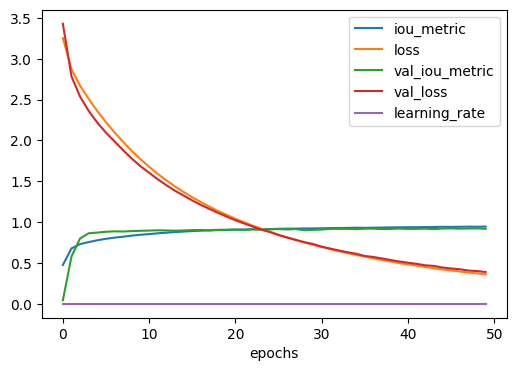

In [17]:
# Show results as plot
pd.DataFrame(history.history).plot(figsize=(6, 4), xlabel="epochs")

In [18]:
from keras.models import load_model
# Save the model and weights after training
model.save("person_segmentation_Unet_Resnet50.keras")

# Load the saved model
model_path = "person_segmentation_Unet_Resnet50.keras"
model = load_model(model_path, custom_objects={"iou_metric": iou_metric})


In [19]:
# Evaluate on test data
test_loss, test_iou = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.2f}")
# print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test IoU: {test_iou:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 742ms/step - iou_metric: 0.9158 - loss: 0.4030
Test Loss: 0.41
Test IoU: 0.91


In [20]:
# Claculate IOU and F1-Score for test data
from sklearn.metrics import f1_score
# Get predictions from the model on test data
y_pred = model.predict(X_test)

# Flatten the arrays to handle individual pixels
y_true_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Threshold predictions to make them binary (0 or 1)
y_pred_binary = (y_pred_flat > 0.5).astype(int)

# Calculate IoU and F1 score
intersection = np.sum(y_true_flat * y_pred_binary)
union = np.sum(y_true_flat) + np.sum(y_pred_binary) - intersection
iou = intersection / union if union != 0 else 0  # Avoid division by zero
f1 = f1_score(y_true_flat, y_pred_binary)

print(f"IoU: {iou:.2f}")
print(f"F1 Score: {f1:.2f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 840ms/step
IoU: 0.91
F1 Score: 0.95


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


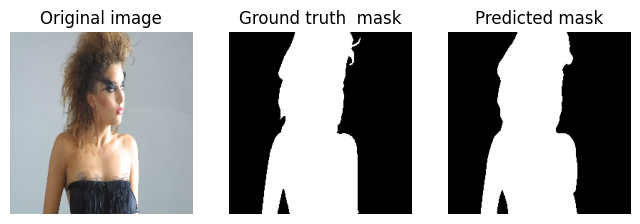

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


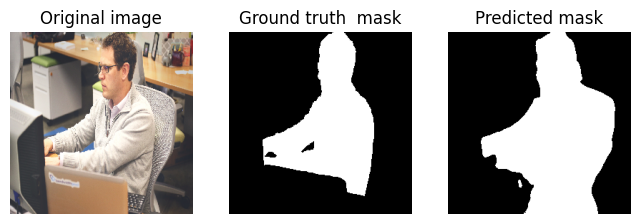

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


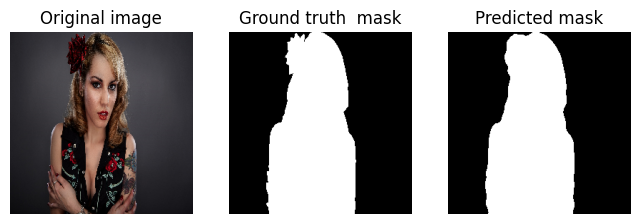

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


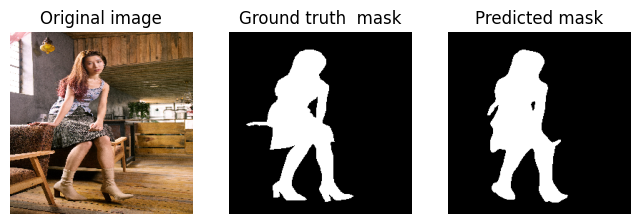

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


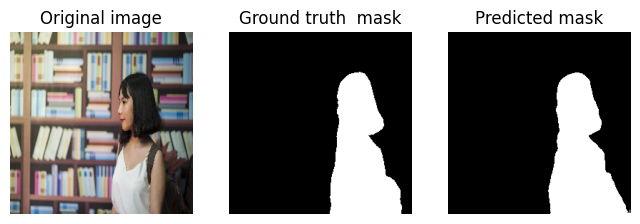

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


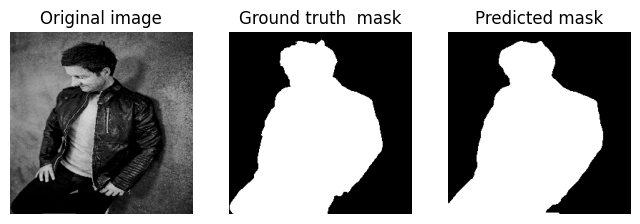

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


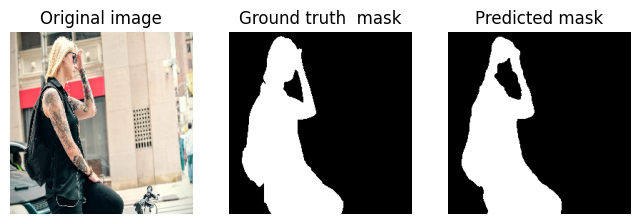

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


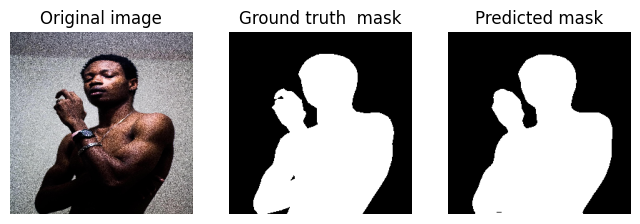

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


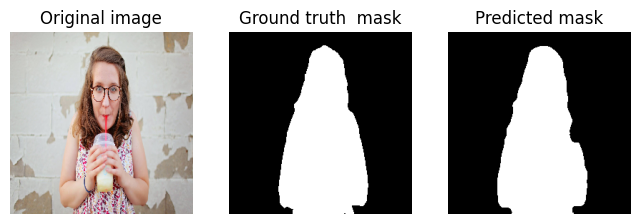

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


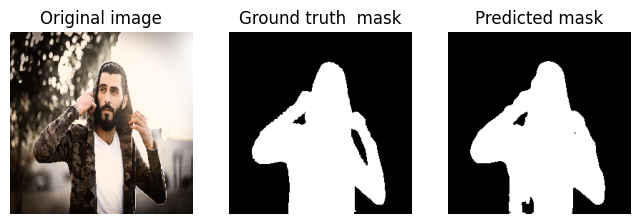

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


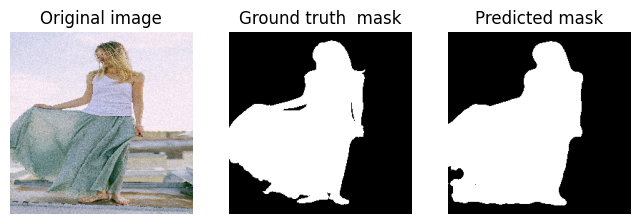

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


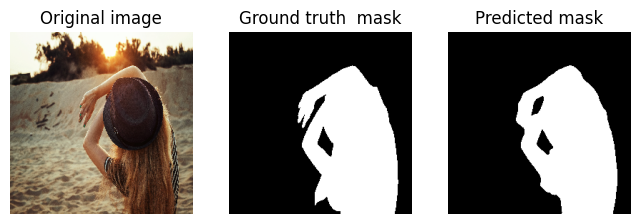

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


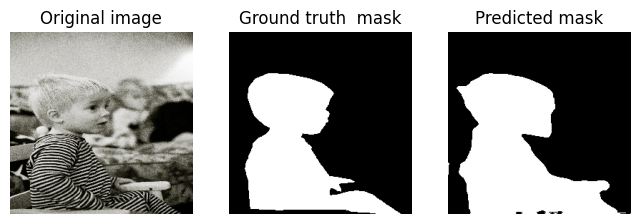

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


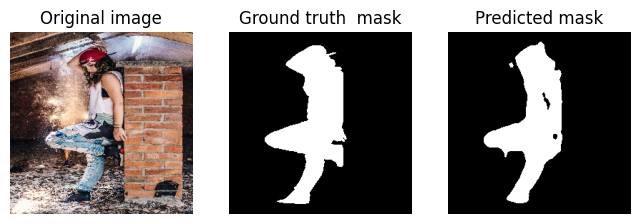

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


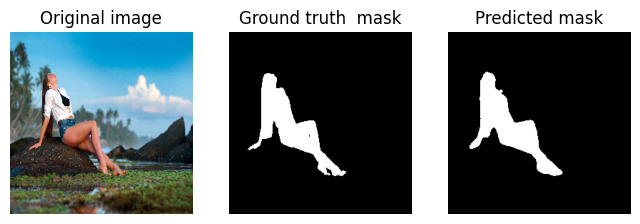

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


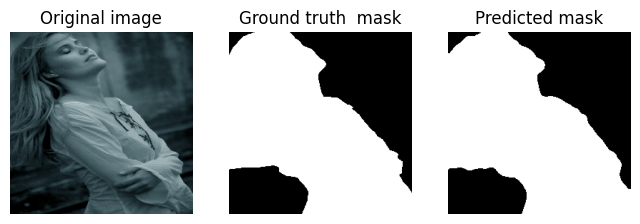

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


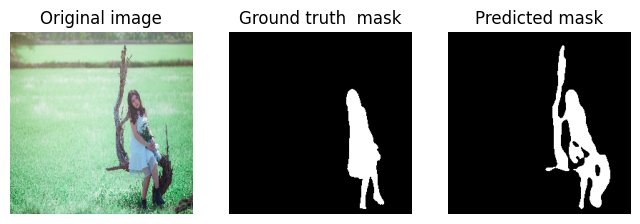

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


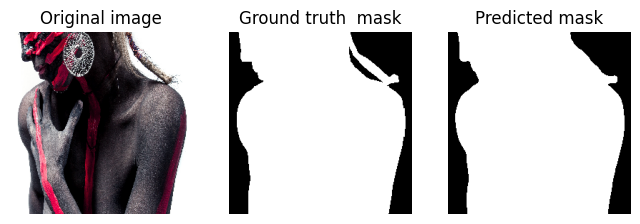

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


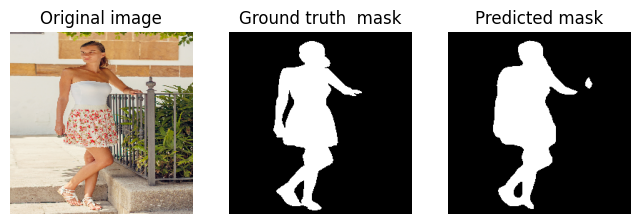

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


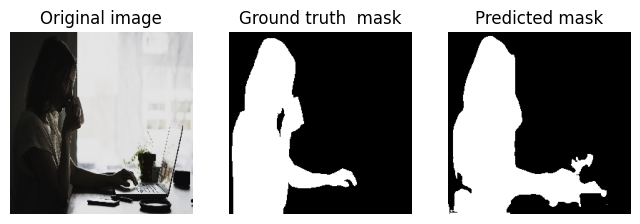

In [21]:
# Visualize the results on test data
def visualize_results(model, X_test, y_test, num_images=5):
    for i in range(num_images):
        # Get the image and true mask
        img = X_test[i]
        true_mask = y_test[i].squeeze()

        # Predict the mask
        y_pred = model.predict(np.expand_dims(img, axis=0))  # Add batch dimension
        pred_mask = (y_pred.squeeze() > 0.5).astype(np.uint8)  # Remove batch dimension and apply threshold

        # Plot the original image, true mask, and predicted mask
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 3, 1)
        plt.title("Original image")
        plt.imshow(img)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Ground truth  mask")
        plt.imshow(true_mask, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Predicted mask")
        plt.imshow(pred_mask, cmap="gray")
        plt.axis("off")

        plt.show()

visualize_results(model, X_test, y_test, num_images=20)